In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from disp import set_plot, colors
from kernels import make_psi_rand_sgm, make_ker_rand_sgm_theory

D = 1

DT = .001

# base system params
TAU = .01
B = np.eye(D)
C = np.eye(D)

# primal form
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)
psi, ker = make_psi_rand_sgm(J_PSI)

f_0 = lambda x: 0

def eval_F(x, u, W):
    return (1/TAU)*(-x + f_0(x) + C@W.T@psi(x) + B@u)

U = np.zeros(D)
X_0 = np.array([1.])
TARG = np.array([1.])
T_MAXS = [.03, .1, 1, 2]

RATE_L = 20  # learning signal rate
SD_L = 1/DT  # learning signal stdev
T_L_MAX = 0.05  # max learning time

NTR = 3
NEPOCH = 100

In [2]:
xs_all = []
xs_frz_all = []
ls_all = []
r_bests_all = []
rs_all = []
keep_all = []

for t_max in T_MAXS:
    sys.stdout.write('>')

    t = np.arange(0, t_max, DT)
    
    xs = np.nan*np.zeros((NTR, NEPOCH, len(t), D))
    xs_frz = np.nan*np.zeros((NTR, NEPOCH, len(t), D))  # for frozen learning
    ls = np.nan*np.zeros((NTR, NEPOCH, len(t), D))
    RS = np.nan*np.zeros((NTR, NEPOCH))
    R_BESTS = np.nan*np.zeros((NTR, NEPOCH))
    keep = np.zeros((NTR, NEPOCH), dtype=bool)
    
    W = np.zeros((N, D))

    for ctr in range(NTR):
        sys.stdout.write('-')
        
        R_BEST = 0
        R_BESTS[ctr, 0] = R_BEST
        
        for cepoch in range(NEPOCH):
            # run learning trial
            R_BESTS[ctr, cepoch] = R_BEST
            
            ## initialize trial
            xs[ctr, cepoch, 0, :] = X_0
            ls[ctr, cepoch, 0, :] = 0
        
            W_ET = W.copy()
        
            for ct, t_ in enumerate(t[1:], 1):
                # update x
                u_noise = .001*np.random.randn(D)/DT
                dx = DT*eval_F(xs[ctr, cepoch, ct-1, :], u=u_noise, W=W_ET)
                xs[ctr, cepoch, ct, :] = xs[ctr, cepoch, ct-1, :] + dx
        
                # sample learning signal
                if (t_ < T_L_MAX) and (np.random.rand() < (RATE_L*DT)):
                    l = np.random.randn(D)*SD_L
                else:
                    l = np.zeros(D)
        
                # update weights
                for d in range(D):
                    dw = DT*psi(xs[ctr, cepoch, ct, :])*l[d]
                    W_ET[:, d] += dw
        
                ls[ctr, cepoch, ct, :] = l
        
            # run frozen trial
            xs_frz[ctr, cepoch, 0, :] = X_0
            for ct, t_ in enumerate(t[1:], 1):
                # update x
                u_noise = .001*np.random.randn(D)/DT
                dx = DT*eval_F(xs_frz[ctr, cepoch, ct-1, :], u=u_noise, W=W_ET)
                xs_frz[ctr, cepoch, ct, :] = xs_frz[ctr, cepoch, ct-1, :] + dx
        
            # get reward
            # R = np.clip(1 - np.linalg.norm(xs[ctr, cepoch, -1, :] - TARG), 0, np.inf)  # eval on learning trial
            R = np.clip(1 - np.linalg.norm(xs_frz[ctr, cepoch, -1, :] - TARG), 0, np.inf)  # eval on frozen trial
        
            # convert W_ET to W if reward improves
            if R > R_BEST:
                W = W_ET
                R_BEST = R
                keep[ctr, cepoch] = True
        
            RS[ctr, cepoch] = R

    print()
    xs_all.append(xs.copy())
    xs_frz_all.append(xs_frz.copy())
    ls_all.append(ls.copy())
    r_bests_all.append(R_BESTS.copy())

    rs_all.append(RS.copy())
    keep_all.append(keep.copy())

>---
>---
>---
>---


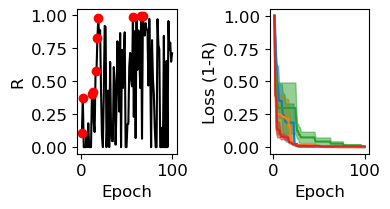

In [3]:
ixpl = 1
RS = rs_all[ixpl][0]
xs = xs_all[ixpl][0]
xs_frz = xs_frz_all[ixpl][0]
ls = ls_all[ixpl][0]
R_BESTS = r_bests_all[ixpl][0]
keep = keep_all[ixpl][0]

# reward stats
fig, axs = plt.subplots(1, 2, figsize=(4, 2.2), tight_layout=True)
axs[0].plot(1+np.arange(NEPOCH), RS, c='k', zorder=0)
axs[0].scatter((1+np.arange(NEPOCH))[keep], RS[keep], c='r', zorder=1)
set_plot(axs[0], x_label='Epoch', y_label='R')
for ct_max, t_max in enumerate(T_MAXS):
    losses = 1-r_bests_all[ct_max].mean(0)
    losses_sem = (1-r_bests_all[ct_max]).std(0)/np.sqrt(NTR)
    axs[1].plot(1+np.arange(NEPOCH), losses, c=colors[ct_max])
    axs[1].fill_between(1+np.arange(NEPOCH), losses-losses_sem, losses+losses_sem, color=colors[ct_max], alpha=.5)
    set_plot(axs[1], x_label='Epoch', y_label='Loss (1-R)')

fig.savefig('ms/5_hold_loss_dope_noise.svg')

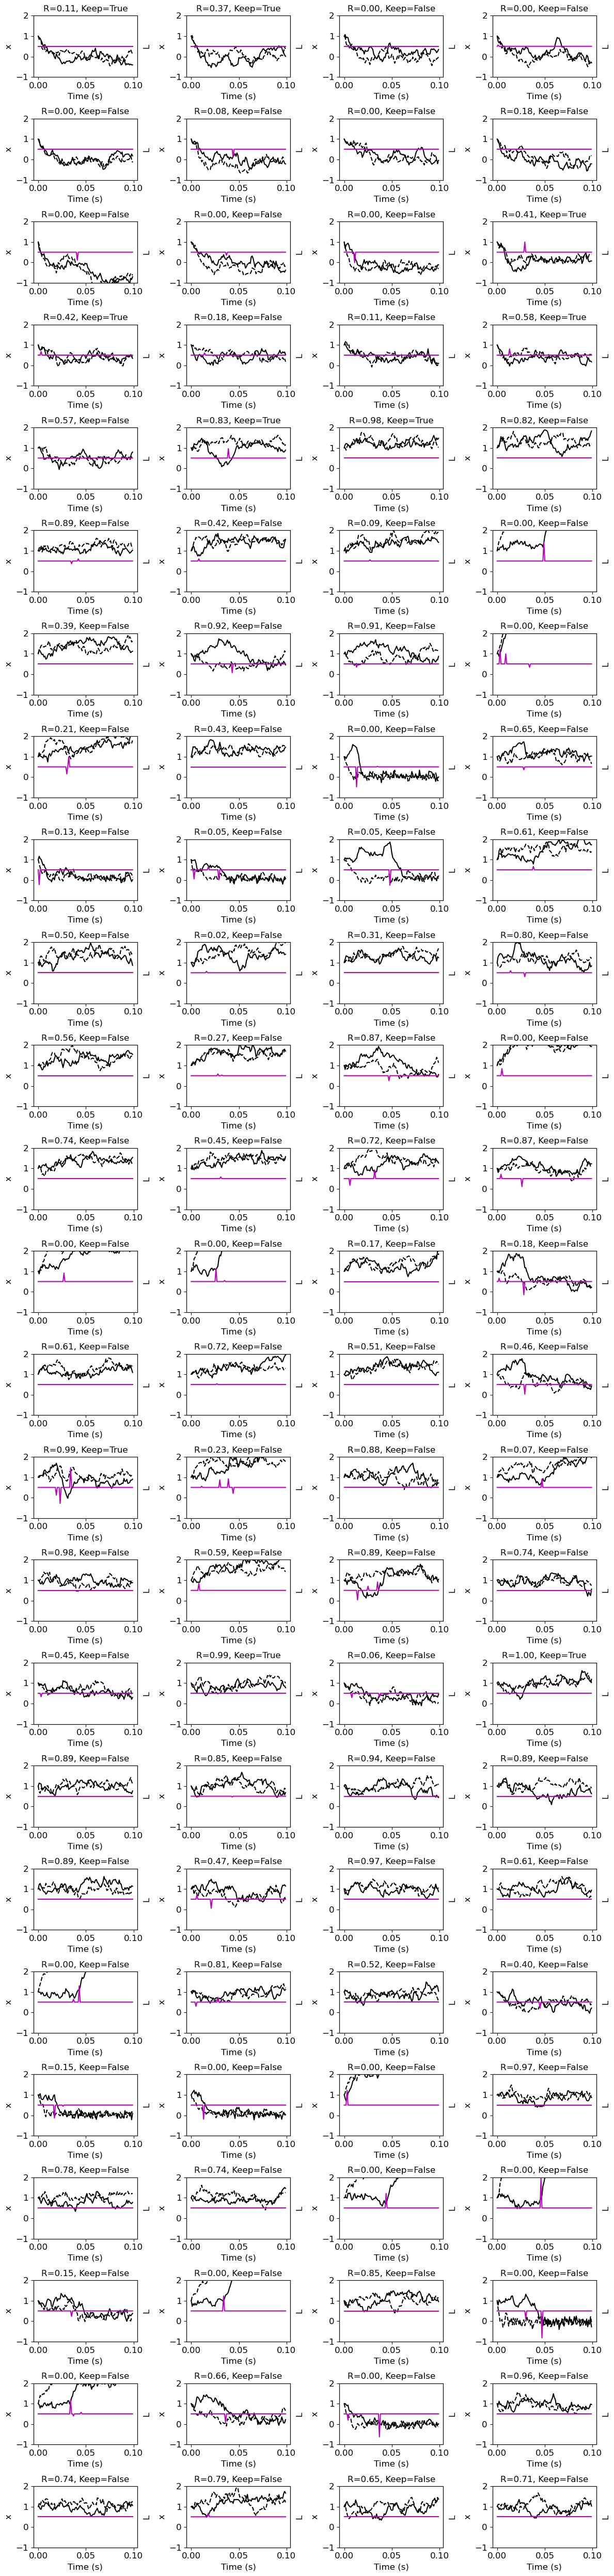

In [4]:
# indiv trials
plot_epochs = True
if plot_epochs:
    t = np.arange(0, T_MAXS[ixpl], DT)
    fig, axs = plt.subplots(NEPOCH//4, 4, figsize=(12, 2*NEPOCH/4), tight_layout=True)
    axs = axs.flatten()
    ax_tws = [ax.twinx() for ax in axs]
    
    for cepoch in range(NEPOCH):
        try:
            ax = axs[cepoch]
        except:
            break
        ax_tw = ax_tws[cepoch]
    
        ax.plot(t, xs[cepoch], c='k')
        ax.plot(t, xs_frz[cepoch], c='k', ls='--')
        ax_tw.plot(t, ls[cepoch], c='m')
        set_plot(ax, y_lim=(-1., 2.), y_label='x', title=f'R={RS[cepoch]:.2f}, Keep={keep[cepoch]}')
        set_plot(ax_tw, y_lim=(-3*SD_L, 3*SD_L), y_ticks=[], y_label='L')
    
    for ax in axs:
        set_plot(ax, x_label='Time (s)')

    fig.savefig('ms/5_hold_trials_dope_noise.svg')